# Q3 Select Your Own Data 

https://www.kaggle.com/imsparsh/churn-risk-rate-hackerearth-ml

### Context
Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. . Every user is assigned a prediction value that estimates their state of churn at any given time. This value is based on:

User demographic information
Browsing behavior
Historical purchase data among other information
It factors in our unique and proprietary predictions of how long a user will remain a customer. This score is updated every day for all users who have a minimum of one conversion. The values assigned are between 1 and 5.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def plot_confusion_matrix(model, X, y):
    y_pred = (model.predict(X)).argmax(axis=-1)
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', alpha=0.8, vmin=0)

The data has 

In [3]:
data = pd.read_csv("./data/Q3/train.csv")
data.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


Dropping irrelevant data. Variables such as Name and  Customer Id should not have any predictive power and will only increase dimensionality.

In [5]:

data.drop(['customer_id', 'Name','security_no', 'referral_id','last_visit_time'], inplace=True, axis=1)

Removing the target variable 

In [6]:
data.drop(data[data.churn_risk_score == -1].index, inplace=True)
data.describe()
data.shape

(35829, 20)

In [7]:
data['region_category'].fillna('other', inplace=True)
data['points_in_wallet'].fillna(0, inplace=True)
data['preferred_offer_types'].fillna(data['preferred_offer_types'].mode()[0], inplace=True)


In [8]:
data['joining_date'] = pd.to_datetime(data['joining_date'])
data['days_since_joined'] = data['joining_date'].apply(lambda x:(pd.Timestamp('today') - x).days)
data.drop(['joining_date'], inplace=True, axis=1)


In [9]:
data['days_since_last_login'] = data["days_since_last_login"].apply(lambda x : x if x >= 0 else 20)

In [10]:
data['avg_time_spent'] = data["avg_time_spent"].apply(lambda x : x if x >= 0 else 0)

In [11]:
data['avg_frequency_login_days'] = data["avg_frequency_login_days"].apply(lambda x : x if x != 'Error' else 0)

data['avg_frequency_login_days'] = pd.to_numeric(data['avg_frequency_login_days'])

In [12]:
# profile = pp.ProfileReport(data)
# profile.to_notebook_iframe()

In [13]:
# plt.rcParams['figure.figsize']=[10,10]
# sns.heatmap(data.corr(),annot=True)

In [12]:
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [13]:
Y_ready = data.pop('churn_risk_score')

In [14]:
numerical_data, categorical_data  = divideFeatures(data)

In [15]:
categorical_data_dummies=pd.get_dummies(categorical_data,drop_first=True)

In [16]:
scaler = preprocessing.StandardScaler()

numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data),columns = numerical_data.columns)


In [17]:
numerical_data_scaled.reset_index(drop=True, inplace=True)
categorical_data_dummies.reset_index(drop=True, inplace=True)

In [18]:
X_ready = pd.concat([numerical_data_scaled, categorical_data_dummies], axis=1)


In [19]:
print(X_ready.shape)
print(numerical_data_scaled.shape)
print(categorical_data_dummies.shape)

(35829, 41)
(35829, 7)
(35829, 34)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_ready, Y_ready, train_size=0.8, random_state=1)

In [21]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, input_shape=(41,), activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))

model.add(keras.layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

fit = model.fit(X_train, y_train, epochs=40 )

model.evaluate(X_train, y_train)

Epoch 1/40
896/896 [==============================] - 10s 8ms/step - loss: 0.8274 - accuracy: 0.5833
Epoch 2/40
896/896 [==============================] - 7s 8ms/step - loss: 0.5470 - accuracy: 0.6861
Epoch 3/40
896/896 [==============================] - 9s 10ms/step - loss: 0.4434 - accuracy: 0.7551
Epoch 4/40
896/896 [==============================] - 9s 10ms/step - loss: 0.3962 - accuracy: 0.7697
Epoch 5/40
896/896 [==============================] - 8s 9ms/step - loss: 0.3839 - accuracy: 0.7825
Epoch 6/40
896/896 [==============================] - 6s 7ms/step - loss: 0.3777 - accuracy: 0.7830
Epoch 7/40
896/896 [==============================] - 5s 5ms/step - loss: 0.3649 - accuracy: 0.7922
Epoch 8/40
896/896 [==============================] - 6s 6ms/step - loss: 0.3659 - accuracy: 0.7906
Epoch 9/40
896/896 [==============================] - 5s 6ms/step - loss: 0.3568 - accuracy: 0.7997
Epoch 10/40
896/896 [==============================] - 5s 5ms/step - loss: 0.3488 - accuracy: 0.8

[0.13956712186336517, 0.9358406066894531]

In [22]:
pred = model.predict(X_test).argmax(axis=-1)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       0.62      0.74      0.67       451
           2       0.77      0.66      0.71       610
           3       0.90      0.91      0.90      2089
           4       0.60      0.66      0.63      1870
           5       0.78      0.71      0.74      2146

    accuracy                           0.75      7166
   macro avg       0.74      0.74      0.73      7166
weighted avg       0.76      0.75      0.75      7166



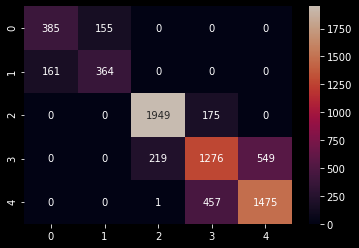

In [58]:
plot_confusion_matrix(model, X_test, y_test)

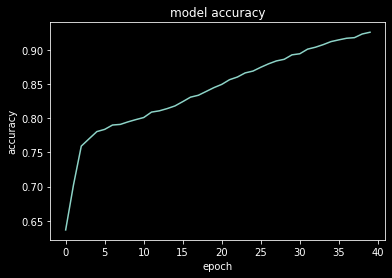

In [23]:
plt.plot(fit.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.svm import SVC
svm = SVC(C=2, kernel='rbf', gamma='auto', verbose=True)
svm.fit(X_train, y_train)

In [24]:
accuracy = svm.score(X_test, y_test)
accuracy

NameError: name 'svm' is not defined